In [6]:
import numpy as np
np.random.seed(42)
import sklearn
import os

import keras
import pickle

from keras.layers.advanced_activations import LeakyReLU 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

import pandas as pd
% matplotlib inline

Using TensorFlow backend.


In [13]:
from keras.models import load_model

model1= load_model('models/CNN.ckpt')
model2 = load_model('models/CNN_BN.ckpt')
# list all data in history




NameError: name 'history' is not defined

In [ ]:
from keras.utils.vis_utils import plot_model  
plot_model(model1, to_file='model.png')  
plot_model(model2, to_file='model2.png')  



![title](model2.png)


# model 1

![title](model.png)

In [14]:
# Load pickled data

def load_split_input_data() :

    # TODO: fill this in based on where you saved the training and testing data
    training_file = './train.p'
    testing_file = './test.p'
    validation_file = './valid.p'


    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)

    X_train, y_train = train['features'], train['labels']
    X_test, y_test = test['features'], test['labels']
    X_val, y_val = valid['features'], valid['labels']

    print(len(X_train))
    print(len(X_test))
    print(len(X_val))
    print(len(y_val))

    # STOP: Do not change the tests below. Your implementation should pass these tests. 
    assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
    assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
    assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
    
    return X_train, y_train, X_test, y_test, X_val, y_val


    





In [15]:
#greyscale
# Convert to grayscale

def convert_to_grayscale(X_train,X_test, X_val):

    X_train_rgb = X_train
    X_val_rgb = X_val
    X_train_gry = np.sum(X_train/3, 
                     axis=3, keepdims=True)

    X_test_rgb = X_test
    X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)
    X_val_gry = np.sum(X_val/3, axis=3, keepdims=True)
    
    print('RGB shape:', X_train_rgb.shape)
    print('Grayscale shape:', X_train_gry.shape)
    X_train = X_train_gry
    X_test = X_test_gry
    X_val = X_val_gry
    
    assert(X_train.shape[1:] == (32,32,1)), "The dimensions of the images are not 32 x 32 x 1."
    return X_train,X_test, X_val

In [16]:
def preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val):

    X_train, X_test , X_val = convert_to_grayscale(X_train, X_test, X_val)
    
    # Shuffle data
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    X_test, y_test = shuffle(X_test, y_test, random_state=42)
    X_val, y_val = shuffle(X_val, y_val, random_state = 42)
    
    # Normalise data
    X_train = (X_train - X_train.mean()) / (np.max(X_train) - np.min(X_train))
    X_test = (X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test))
    X_val = (X_val - X_val.mean())/(np.max(X_val)-np.min(X_val))
    # One-hot encode labels
    y_train = np_utils.to_categorical(y_train,num_classes=43)
    y_test = np_utils.to_categorical(y_test, num_classes=43)
    y_val = np_utils.to_categorical(y_val, num_classes=43)

    

    print("X_train: ", len(X_train))
    print("y_train: ", len(y_train))
    print("X_val: ", len(X_val))
    print("y_val: ", len(y_val))
    return X_train, y_train, X_test, y_test, X_val, y_val


In [17]:
X_train, y_train, X_test, y_test,X_val,y_val = load_split_input_data()
X_train, X_test,X_val = convert_to_grayscale(X_train, X_test,X_val)
X_train, y_train, X_test, y_test, X_val,y_val = preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val)
print(len(X_train))

34799
12630
4410
4410
RGB shape: (34799, 32, 32, 3)
Grayscale shape: (34799, 32, 32, 1)
RGB shape: (34799, 32, 32, 1)
Grayscale shape: (34799, 32, 32, 1)
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
34799


In [18]:
# Save the data for easy access

pickle_file = 'preprocessed_data.p'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'y_train': y_train,
                    'X_train': X_train,
                    'X_val': X_val,
                    'y_val': y_val,
                    'X_test': X_test,
                    'y_test': y_test
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


In [7]:
import sklearn
import os

import keras
import pickle
pickle_file = 'preprocessed_data.p'

# Reload the data
print(pickle_file)
with open(pickle_file, 'rb') as f:
      pickle_data = pickle.load(f)
      X_train = pickle_data['X_train']
      print(len(X_train))
      y_train = pickle_data['y_train']
      X_val = pickle_data['X_val']
      y_val = pickle_data['y_val']
      X_test = pickle_data['X_test']
      y_test = pickle_data['y_test']
      del pickle_data  # Free up memory
      print("X_train: ", len(X_train))
      print("y_train: ", len(y_train))
      print("X_val: ", len(X_val))
      print("y_val: ", len(y_val))
      print("X_test: ", len(X_test))
      print("y_test: ", len(y_test))

      print('Data and modules loaded.')


preprocessed_data.p
34799
X_train:  34799
y_train:  34799
X_val:  4410
y_val:  4410
X_test:  12630
y_test:  12630
Data and modules loaded.


# SPATIAL TRANSFORMER 

In [19]:
from keras.layers.core import Layer
import tensorflow as tf

class SpatialTransformer(Layer):
    """Spatial Transformer Layer
    Implements a spatial transformer layer as described in [1]_.
    Borrowed from [2]_:
    downsample_fator : float
        A value of 1 will keep the orignal size of the image.
        Values larger than 1 will down sample the image. Values below 1 will
        upsample the image.
        example image: height= 100, width = 200
        downsample_factor = 2
        output image will then be 50, 100
    References
    ----------
    .. [1]  Spatial Transformer Networks
            Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
            Submitted on 5 Jun 2015
    .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
    .. [3]  https://github.com/EderSantana/seya/blob/keras1/seya/layers/attention.py
    """

    def __init__(self,
                 localization_net,
                 output_size,
                 **kwargs):
        self.locnet = localization_net
        self.output_size = output_size
        super(SpatialTransformer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.locnet.build(input_shape)
        self.trainable_weights = self.locnet.trainable_weights
        #self.regularizers = self.locnet.regularizers //NOT SUER ABOUT THIS, THERE IS NO MORE SUCH PARAMETR AT self.locnet
        #self.constraints = self.locnet.constraints

    def compute_output_shape(self, input_shape):
        output_size = self.output_size
        return (None,
                int(output_size[0]),
                int(output_size[1]),
                int(input_shape[-1]))

    def call(self, X, mask=None):
        affine_transformation = self.locnet.call(X)
        output = self._transform(affine_transformation, X, self.output_size)
        return output

    def _repeat(self, x, num_repeats):
        ones = tf.ones((1, num_repeats), dtype='int32')
        x = tf.reshape(x, shape=(-1,1))
        x = tf.matmul(x, ones)
        return tf.reshape(x, [-1])

    def _interpolate(self, image, x, y, output_size):
        batch_size = tf.shape(image)[0]
        height = tf.shape(image)[1]
        width = tf.shape(image)[2]
        num_channels = tf.shape(image)[3]

        x = tf.cast(x , dtype='float32')
        y = tf.cast(y , dtype='float32')

        height_float = tf.cast(height, dtype='float32')
        width_float = tf.cast(width, dtype='float32')

        output_height = output_size[0]
        output_width  = output_size[1]

        x = .5*(x + 1.0)*(width_float)
        y = .5*(y + 1.0)*(height_float)

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        max_y = tf.cast(height - 1, dtype='int32')
        max_x = tf.cast(width - 1,  dtype='int32')
        zero = tf.zeros([], dtype='int32')

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        flat_image_dimensions = width*height
        pixels_batch = tf.range(batch_size)*flat_image_dimensions
        flat_output_dimensions = output_height*output_width
        base = self._repeat(pixels_batch, flat_output_dimensions)
        base_y0 = base + y0*width
        base_y1 = base + y1*width
        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = tf.reshape(image, shape=(-1, num_channels))
        flat_image = tf.cast(flat_image, dtype='float32')
        pixel_values_a = tf.gather(flat_image, indices_a)
        pixel_values_b = tf.gather(flat_image, indices_b)
        pixel_values_c = tf.gather(flat_image, indices_c)
        pixel_values_d = tf.gather(flat_image, indices_d)

        x0 = tf.cast(x0, 'float32')
        x1 = tf.cast(x1, 'float32')
        y0 = tf.cast(y0, 'float32')
        y1 = tf.cast(y1, 'float32')

        area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
        output = tf.add_n([area_a*pixel_values_a,
                           area_b*pixel_values_b,
                           area_c*pixel_values_c,
                           area_d*pixel_values_d])
        return output

    def _meshgrid(self, height, width):
        x_linspace = tf.linspace(-1., 1., width)
        y_linspace = tf.linspace(-1., 1., height)
        x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
        x_coordinates = tf.reshape(x_coordinates, [-1])
        y_coordinates = tf.reshape(y_coordinates, [-1])
        ones = tf.ones_like(x_coordinates)
        indices_grid = tf.concat([x_coordinates, y_coordinates, ones], 0)
        return indices_grid

    def _transform(self, affine_transformation, input_shape, output_size):
        batch_size = tf.shape(input_shape)[0]
        height = tf.shape(input_shape)[1]
        width = tf.shape(input_shape)[2]
        num_channels = tf.shape(input_shape)[3]

        affine_transformation = tf.reshape(affine_transformation, shape=(batch_size,2,3))

        affine_transformation = tf.reshape(affine_transformation, (-1, 2, 3))
        affine_transformation = tf.cast(affine_transformation, 'float32')

        width = tf.cast(width, dtype='float32')
        height = tf.cast(height, dtype='float32')
        output_height = output_size[0]
        output_width = output_size[1]
        indices_grid = self._meshgrid(output_height, output_width)
        indices_grid = tf.expand_dims(indices_grid, 0)
        indices_grid = tf.reshape(indices_grid, [-1]) # flatten?

        indices_grid = tf.tile(indices_grid, tf.stack([batch_size]))
        indices_grid = tf.reshape(indices_grid, (batch_size, 3, -1))

        transformed_grid = tf.matmul(affine_transformation, indices_grid)
        x_s = tf.slice(transformed_grid, [0, 0, 0], [-1, 1, -1])
        y_s = tf.slice(transformed_grid, [0, 1, 0], [-1, 1, -1])
        x_s_flatten = tf.reshape(x_s, [-1])
        y_s_flatten = tf.reshape(y_s, [-1])

        transformed_image = self._interpolate(input_shape,
                                                x_s_flatten,
                                                y_s_flatten,
                                                output_size)

        transformed_image = tf.reshape(transformed_image, shape=(batch_size,
                                                                output_height,
                                                                output_width,
                                                                num_channels))
        return transformed_image


# LOCNET

In [20]:
def locnet():

    # initial weights
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((50, 6), dtype='float32')
    weights = [W, b.flatten()]

    input_shape = (32,32,1)

    #locnet
    locnet = Sequential()
    locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
    locnet.add(Conv2D(20, (5, 5)))
    locnet.add(MaxPooling2D(pool_size=(2,2)))
    locnet.add(Conv2D(20, (5, 5)))

    locnet.add(Flatten())
    locnet.add(Dense(50))
    model.add(LeakyReLU(alpha=0.5))
    locnet.add(Dense(6, weights=weights))
    return locnet
    #locnet.add(Activation('sigmoid'))

#  CNN model 

In [8]:
def cnn_model(flag_BN=False, flag_STN=False):

    
    model = Sequential()
    if flag_STN == True:
        lnet = locnet()
        print(lnet)
        model.add(SpatialTransformer(localization_net=lnet,
                            input_shape=(32,32,1),output_size=(32,32)))
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=( 32, 32,1)))                    
    #model.add(Conv2D(32, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))

    #model.add(Conv2D(64, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same'))
    #model.add(Conv2D(128, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))

    model.summary()
    return model

# CNN without Batch Normalization

In [22]:
model = cnn_model()
# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=512, nb_epoch=20,
                    verbose=1, validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================] - 14s - loss: 2.7570 - acc: 0.2625 - val_loss: 1.8260 - val_acc: 0.5141
Epoch 2/20
34799/34799 [==============================] - 10s - loss: 0.9570 - acc: 0.7186 - val_loss: 0.9187 - val_acc: 0.7644
Epoch 3/20
34799/34799 [==============================] - 10s - loss: 0.4421 - acc: 0.8690 - val_loss: 0.6378 - val_acc: 0.8392
Epoch 4/20
34799/34799 [==============================] - 10s - loss: 0.2799 - acc: 0.9179 - val_loss: 0.5354 - val_acc: 0.8703
Epoch 5/20
34799/34799 [==============================] - 10s - loss: 0.1894 - acc: 0.9458 - val_loss: 0.4878 - val_acc: 0.8859
Epoch 6/20
34799/34799 [==============================] - 10s - loss: 0.1478 - acc: 0.9584 - val_loss: 0.4475 - val_acc: 0.8950
Epoch 7/20
34799/34799 [==============================] - 10s - loss: 0.1236 - acc: 0.9636 - val_loss: 0.4609 - val_acc: 0.8807
Epoch 8/20
34799/34799 [==============================]

In [ ]:
#save

import matplotlib.pyplot as plt  
plt.figure(1)  
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  


with open('CNN_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


{'val_acc': [0.51405895797033163, 0.76439909378146909, 0.83922902634895302, 0.87029478601317289, 0.88594104135387874, 0.89501133932818633, 0.88072562558310374, 0.91315192522105171, 0.91065759839925098, 0.9170068047484573, 0.91201814261693803, 0.91655329054986001, 0.91995464949921413, 0.92267573579909312, 0.9242630373863947, 0.91814058629833917, 0.92947845848239197, 0.93356009221671665, 0.93151927215982722, 0.92925170111277744], 'val_loss': [1.8259861672546318, 0.91865875472287206, 0.63779906388583363, 0.53541929000088961, 0.48778515337816442, 0.44754030974814141, 0.46086741388519875, 0.3860022514044833, 0.37977416008508125, 0.39402617929744072, 0.41285653779295839, 0.36605362466403418, 0.37229382028114771, 0.38517394522690718, 0.36486099144769091, 0.38345984263755295, 0.3405439810417677, 0.29562408975462795, 0.29894929083566818, 0.32533580637843162], 'acc': [0.26253628017381742, 0.71855513143753191, 0.86901922507575058, 0.91792867693353919, 0.94580304091160128, 0.95844708315383886, 0.9

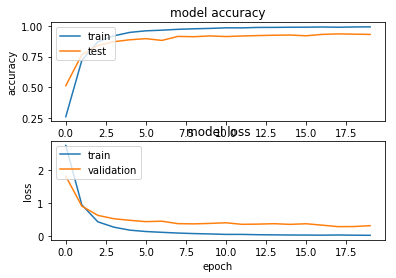

In [14]:
#load

import pickle

history_cnn = pickle.load( open( "CNN_history", "rb" ) )
print(history_cnn)
print(history_cnn.keys())  


import matplotlib.pyplot as plt  
plt.figure(1)  
plt.subplot(211)  
plt.plot(history_cnn['acc'])  
plt.plot(history_cnn['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history_cnn['loss'])  
plt.plot(history_cnn['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  




#from keras.models import load_model

#model.save('CNN.h5')  # creates a HDF5 file 'my_model.h5'
#f = open(historyfile, 'wb')
#pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
#f.close()


# returns a compiled model
# identical to the previous one
#model = load_model('CNN.h5')


#model.save('models/CNN.ckpt')
#model.evaluate(X_test,y_test)

# CNN  with Batch Normalization

In [9]:
model = cnn_model(flag_BN=True)
# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=512, nb_epoch=20,
                    verbose=1, validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
__________

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================] - 20s - loss: 1.9953 - acc: 0.4775 - val_loss: 3.5056 - val_acc: 0.0696
Epoch 2/20
34799/34799 [==============================] - 16s - loss: 0.6265 - acc: 0.8121 - val_loss: 3.6536 - val_acc: 0.0841
Epoch 3/20
34799/34799 [==============================] - 16s - loss: 0.3486 - acc: 0.8976 - val_loss: 3.1759 - val_acc: 0.2002
Epoch 4/20
34799/34799 [==============================] - 16s - loss: 0.2449 - acc: 0.9299 - val_loss: 2.7885 - val_acc: 0.3259
Epoch 5/20
34799/34799 [==============================] - 16s - loss: 0.1843 - acc: 0.9476 - val_loss: 1.8120 - val_acc: 0.5351
Epoch 6/20
34799/34799 [==============================] - 16s - loss: 0.1446 - acc: 0.9591 - val_loss: 1.2360 - val_acc: 0.6463
Epoch 7/20
34799/34799 [==============================] - 16s - loss: 0.1111 - acc: 0.9684 - val_loss: 0.7632 - val_acc: 0.7939
Epoch 8/20
34799/34799 [==============================]

In [10]:
model.save('models/CNN_BN.ckpt')


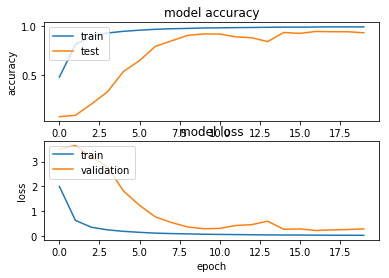

In [11]:
import matplotlib.pyplot as plt  

history_bn = history
plt.figure(1)  
plt.subplot(211)  
plt.plot(history_bn.history['acc'])  
plt.plot(history_bn.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history_bn.history['loss'])  
plt.plot(history_bn.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  


with open('CNN_BN_history', 'wb') as file_pi:
        pickle.dump(history_bn.history, file_pi)


{'val_acc': [0.06961451252233955, 0.08412698418442624, 0.20022675805891993, 0.32585033883853837, 0.53514739283088109, 0.64625850196868651, 0.79387755610234612, 0.84943310852223786, 0.90544217673559035, 0.92086168268099933, 0.91950113475998518, 0.89070294876487888, 0.88117913340224696, 0.84172335952317634, 0.9356009106517108, 0.92630385690265227, 0.9458049944198591, 0.9433106612186043, 0.94285714277604815, 0.93242631066683468], 'loss': [1.9953249581309105, 0.62648496088370076, 0.34863655900279661, 0.24490775232900988, 0.18429271632991148, 0.14464727055602877, 0.11114999467630168, 0.093776666597416111, 0.081090261822010734, 0.068098436226916456, 0.059444362380779756, 0.053858994257270601, 0.047153429915514203, 0.041025107344226826, 0.036135932967007241, 0.035046069489796751, 0.030458797292434923, 0.027050494451494687, 0.026726905947902849, 0.024096010072076658], 'acc': [0.47754245807036622, 0.81206356486683862, 0.89761200042020184, 0.92994051556973767, 0.94755596352389515, 0.959050548150

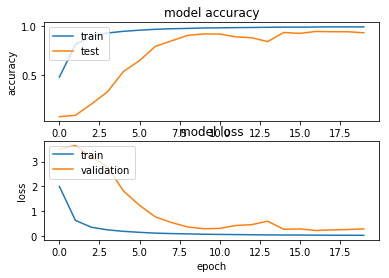

In [12]:
#load

import pickle

history_bn = pickle.load( open( "CNN_BN_history", "rb" ) )
print(history_bn)
print(history_bn.keys())  


import matplotlib.pyplot as plt  
plt.figure(1)  
plt.subplot(211)  
plt.plot(history_bn['acc'])  
plt.plot(history_bn['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history_bn['loss'])  
plt.plot(history_bn['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  






#from keras.models import load_model

#model.save('CNN.h5')  # creates a HDF5 file 'my_model.h5'
#f = open(historyfile, 'wb')
#pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
#f.close()


# returns a compiled model
# identical to the previous one
#model = load_model('CNN.h5')


#model.save('models/CNN.ckpt')
#model.evaluate(X_test,y_test)

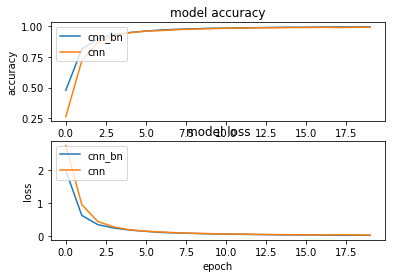

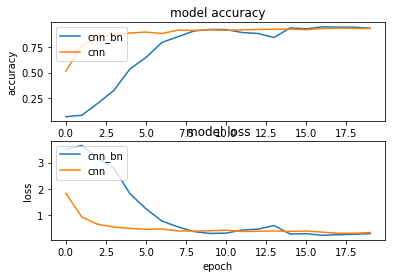

In [17]:



plt.figure(1)  
plt.subplot(211)  
plt.plot(history_bn['acc'])  
plt.plot(history_cnn['acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['cnn_bn', 'cnn'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history_bn['loss'])  
plt.plot(history_cnn['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['cnn_bn', 'cnn'], loc='upper left')  
plt.show()  


plt.figure(1)  

plt.subplot(211)  
plt.plot(history_bn['val_acc'])  
plt.plot(history_cnn['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['cnn_bn', 'cnn'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history_bn['val_loss'])  
plt.plot(history_cnn['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['cnn_bn', 'cnn'], loc='upper left')  
plt.show()  

In [18]:
evaluate = model.evaluate(X_test,y_test)


12630/12630 [==============================] - 3s     


In [21]:
print(evaluate)

AttributeError: 'list' object has no attribute 'keys'

# CNN with Batch Normalization and Data Augmentation

In [31]:

#data augmentation

from keras.preprocessing.image import ImageDataGenerator

def get_datagen():


    datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

    return datagen

In [62]:
model = cnn_model(flag_BN=True)
# Compile and train the model



model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Train again
epochs = 1
datagen = get_datagen()
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=512),
                    steps_per_epoch=X_train.shape[0],
                              
                    epochs=100,verbose=1,
                    validation_data=(X_val, y_val)
                    #callbacks=[LearningRateScheduler(lr_schedule),
                    #           ModelCheckpoint('model.h5', save_best_only=True)]
                    )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_53 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_54 (Batc (None, 16, 16, 64)        256       
__________

KeyboardInterrupt: 

# CNN with Batch Normalization and Spatial Transformer, No Data Augmentation

## Spatial Transformer

## Locnet

## STN CNN Model with Batch Normalization

In [45]:


model = cnn_model(flag_BN=True,flag_STN=True)

# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=512, nb_epoch=100
                    ,
                    verbose=1, validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_transformer_8 (Spati (None, 32, 32, 1)         14896     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_50 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 16, 16, 64)        18496     
__________

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 34799 samples, validate on 4410 samples
Epoch 1/100
34799/34799 [==============================] - 17s - loss: 2.3574 - acc: 0.3822 - val_loss: 3.7336 - val_acc: 0.0476
Epoch 2/100
34799/34799 [==============================] - 16s - loss: 0.5972 - acc: 0.8214 - val_loss: 3.7187 - val_acc: 0.1150
Epoch 3/100
34799/34799 [==============================] - 16s - loss: 0.2590 - acc: 0.9248 - val_loss: 3.9177 - val_acc: 0.1032
Epoch 4/100
34799/34799 [==============================] - 16s - loss: 0.1536 - acc: 0.9575 - val_loss: 2.7077 - val_acc: 0.2912
Epoch 5/100
34799/34799 [==============================] - 16s - loss: 0.1095 - acc: 0.9706 - val_loss: 1.5999 - val_acc: 0.5544
Epoch 6/100
34799/34799 [==============================] - 16s - loss: 0.0788 - acc: 0.9777 - val_loss: 1.2531 - val_acc: 0.6392
Epoch 7/100
34799/34799 [==============================] - 16s - loss: 0.0597 - acc: 0.9840 - val_loss: 0.7405 - val_acc: 0.7866
Epoch 8/100
34799/34799 [=======================

In [46]:
model.save('models/STN_BN_CNN.ckpt')
model.evaluate(X_test,y_test)

12608/12630 [============================>.] - ETA: 0s

[0.18702008974689474, 0.95566112438271378]

# CNN with STN, Batch Normalization and Data Augmentation

In [59]:

model = cnn_model(flag_BN=True,flag_STN=True)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

epochs = 5
datagen = get_datagen()
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=512),
                    steps_per_epoch=X_train.shape[0],
                    epochs=100,verbose=1,
                    validation_data=(X_val, y_val)
                    #callbacks=[LearningRateScheduler(lr_schedule),
                    #           ModelCheckpoint('model.h5', save_best_only=True)]
                    )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_transformer_11 (Spat (None, 32, 32, 1)         14896     
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_49 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 16, 16, 64)        18496     
__________

KeyboardInterrupt: 

In [60]:
model.save('models/STN_BN_DA_CNN.ckpt')


In [61]:
model.evaluate(X_test, y_test)

12608/12630 [============================>.] - ETA: 0s

[0.056696130254824374, 0.98875692794932701]

34799


# OTHER STUFF

In [24]:
#Keras tutorial 
from keras.callbacks import LearningRateScheduler, ModelCheckpoint


def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(32,32,3),
                     activation='relu'))
    #model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    #model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    #model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))
    return model



datagen = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.,)

model = cnn_model()
# let's train the model using SGD + momentum (how original).
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

nb_epoch = 30
model.fit_generator(datagen.flow(X_train, y_train  , batch_size=128),
                            steps_per_epoch=X_train.shape[0],
                            epochs=nb_epoch,
                            validation_data=(X_val, y_val),
                            callbacks=[LearningRateScheduler(lr_schedule),
                                       ModelCheckpoint('model.h5',save_best_only=True)]
                           )

NameError: name 'LearningRateScheduler' is not defined

In [ ]:
import os
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Convolution2D,Conv2D,MaxPooling2D,Flatten
from keras.optimizers import Adam

# number of classes
nb_classes = 43
# input image dimensions
img_rows, img_cols, img_ch = 32, 32, 3
# number of convolutional filters to use
nb_filter1 = 32
nb_filter2 = 64
nb_filter3 = 128
# size of pooling area for max pooling
pool_size = (2, 2)
pool_strides = (1,1)
# convolution kernel size
kernel_size = (5, 5)
# number of hidden units in the first fully connected layer
nb_fc1=512
nb_fc2=128



model = Sequential()

# Convolution / Max / Pooling / Dropout

model.add(Conv2D(32, (5, 5), border_mode='same', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Activation('relu'))

#model.add(Conv2D(32, (5, 5), border_mode='same', input_shape=(32, 32, 3)))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))
#model.add(Activation('relu'))


#model.add(Conv2D(nb_filter1, kernel_size, strides=pool_strides, padding='same', data_format="channels_last", 
#                    input_shape=(img_rows,img_cols,img_ch),name='conv1'))
#model.add(MaxPooling2D(pool_size=pool_size,strides=pool_strides,name='maxpool1'))
#model.add(Dropout(0.5))

#model.add(Activation('relu',name='relu1'))
model.add(Conv2D(nb_filter2, kernel_size,strides=pool_strides,padding='same',name='conv2'))
model.add(Activation('relu',name='relu2'))
model.add(MaxPooling2D(pool_size=pool_size,strides=None,name='maxpool2'))
model.add(Conv2D(nb_filter3, kernel_size,padding='same',strides=pool_strides, 
                        name='conv3'))
model.add(Activation('relu',name='relu3'))
model.add(MaxPooling2D(pool_size=pool_size,strides=None,name='maxpool3'))
model.add(Flatten(name='flatten'))
model.add(Dropout(0.5,name='dropout1'))
model.add(Dense(nb_fc1, name='hidden1'))
model.add(Activation('relu',name='relu4'))
model.add(Dropout(0.5,name='dropout2'))
model.add(Dense(nb_fc2,  name='hidden2'))
model.add(Activation('relu',name='relu5'))
model.add(Dense(nb_classes, name='output'))
model.add(Activation('softmax',name='softmax'))

model.summary()


nb_epoch = 10
batch_size=128



adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam,
          loss='categorical_crossentropy',
          metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=2, validation_data=(X_val, Y_val))



# STOP: Do not change the tests below. Your implementation should pass these tests.
assert(history.history['val_acc'][-1] > 0.9), "The validation accuracy is: %.3f" % history.history['val_acc'][-1]